# VGG19 with CIFAR-10

This code is trained by adding various attention blocks to the first layer of VGG19 with dataset CIFAR-10.<br>
Then, the inference results of the models are compared and analyzed.

The attention blocks used in the analysis are as follows.
 - Base model (without adding any attention blocks)
 - SE (residual) + SA
 - SE + SA
 - CBAM
 - Our model

In [1]:
import os
import numpy as np
import random
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from vgg_cifar import vgg

## Set hyperparameters

In [2]:
class VGG_agrument:
    def __init__(self):
        self.arch = 'vgg19_bn'  #  Choice : 'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'
        self.workers = 4
        self.epochs = 2 # 300
        self.start_epoch = 0
        self.batch_size = 128
        self.lr = 0.05
        self.momentum = 0.9
        self.weight_decay = 5e-4
        self.print_freq = -1
        self.resume = ''
        self.evaluate = False
        self.pretrained = False
        self.half = False
        self.cpu = False
        self.save_dir = 'weights/vgg19'
        self.dataset = 'cifar10'  # Choice : 'cifar10' and 'cifar100'
        self.block = 'VGG19'
        self.checkpoint = None

args = VGG_agrument()

In [3]:
block_list = ['VGG19', 'SE_SA_1', 'SEC_SA_1', 'CBAM_1', 'NEW_1']
name_list = ['VGG19 (base)', 'SE (residual) + SA', 'SE + SA', 'CBAM', 'Our model']

## Set the random seed

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Training

## 1.1 Implement functions

In [5]:
def train(train_loader, model, criterion, optimizer, epoch, is_cpu, is_half, print_freq):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    if print_freq < 0:
        print_freq = len(train_loader) - 1
    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        if is_cpu == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
        if is_half:
            input = input.half()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader)-1, batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))


def validate(val_loader, model, criterion, is_cpu, is_half, print_freq):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    if print_freq < 0:
        print_freq = len(val_loader) - 1
    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        if is_cpu == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

        if is_half:
            input = input.half()

        # compute output
        with torch.no_grad():
            output = model(input)
            loss = criterion(output, target)

        output = output.float()
        loss = loss.float()

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader)-1, batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))


    return top1.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(lr, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    new_lr = lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [6]:
def run_train(args):
    if args.dataset == "cifar10" :
        num_classes = 10
    elif args.dataset == "cifar100" :
        num_classes = 100
    print("dataset : ", args.dataset)
    print("num classes : ", num_classes)

    # Check the save_dir exists or not
    save_path = os.path.join(args.save_dir, args.dataset, args.block)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    model = vgg.__dict__[args.arch](num_classes, args.block)

    model.features = torch.nn.DataParallel(model.features)
    if args.cpu:
        model.cpu()
    else:
        model.cuda()

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.evaluate, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    # cudnn.benchmark = False

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    if args.dataset == "cifar10":
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

        val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)
    elif args.dataset == "cifar100" :
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

        val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)
    

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss()
    if args.cpu:
        criterion = criterion.cpu()
    else:
        criterion = criterion.cuda()

    if args.half:
        model.half()
        criterion.half()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)    

    if args.evaluate:
        validate(val_loader, model, criterion, args.cpu, args.half, args.print_freq)
        return

    best_prec1 = 0
    epoch_accuracys = []
    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(args.lr, optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, args.cpu, args.half, args.print_freq)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion, args.cpu, args.half, args.print_freq)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        if is_best:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best, filename=os.path.join(save_path, 'checkpoint_{}.tar'.format(epoch)))
        
        # Accumulated precisions
        epoch_accuracys.append(prec1)
    
    return epoch_accuracys

## 1.2 Train models

In [7]:
color_list = ['r', 'y', 'b', 'm', 'g']

In [8]:
accuracy_list = []
for bt, bn in zip(block_list, name_list):
    print()
    print('########################################################################################')
    print('Training of "%s"' %bn)
    args.block = bt
    accuracys = run_train(args)
    accuracy_list.append(accuracys)
    print('########################################################################################')


########################################################################################
Training of "VGG19 (base)"
dataset :  cifar10
num classes :  10
Files already downloaded and verified
Epoch: [0][0/390]	Time 14.907 (14.907)	Data 9.798 (9.798)	Loss 2.3046 (2.3046)	Prec@1 14.062 (14.062)
Epoch: [0][390/390]	Time 0.029 (0.100)	Data 0.000 (0.025)	Loss 1.5114 (1.7785)	Prec@1 38.750 (31.120)
Test: [0/78]	Time 5.695 (5.695)	Loss 1.5055 (1.5055)	Prec@1 48.438 (48.438)
Test: [78/78]	Time 0.013 (0.087)	Loss 1.6387 (1.6267)	Prec@1 43.750 (40.680)
 * Prec@1 40.680
Epoch: [1][0/390]	Time 6.862 (6.862)	Data 6.798 (6.798)	Loss 1.4055 (1.4055)	Prec@1 44.531 (44.531)
Epoch: [1][390/390]	Time 0.041 (0.081)	Data 0.000 (0.018)	Loss 1.0492 (1.3557)	Prec@1 67.500 (51.228)
Test: [0/78]	Time 5.338 (5.338)	Loss 1.4818 (1.4818)	Prec@1 49.219 (49.219)
Test: [78/78]	Time 0.004 (0.089)	Loss 1.6218 (1.5587)	Prec@1 50.000 (46.970)
 * Prec@1 46.970
##############################################################

## 1.3 Display the accuracy

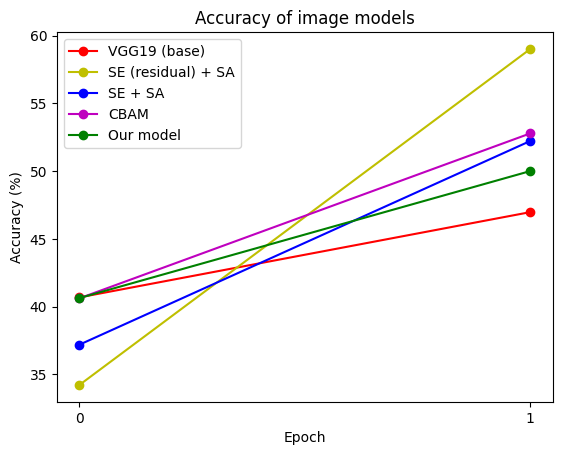

In [9]:
ax = plt.figure()
ax.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
for ba, bn, bc in zip(accuracy_list, name_list, color_list):
    plt.plot(ba, label = bn, color = bc, marker='o')
#plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
#plt.ylim([0, 20])     # Y축의 범위: [ymin, ymax]
plt.title('Accuracy of image models')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

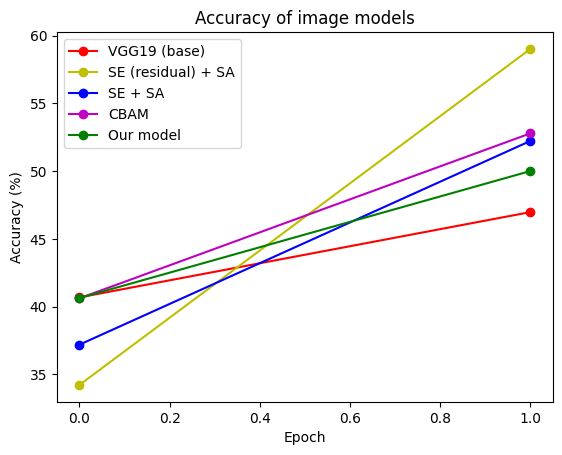

In [10]:
plt.figure()
for ba, bn, bc in zip(accuracy_list, name_list, color_list):
    plt.plot(ba, label = bn, color = bc, marker='o')
#plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
#plt.ylim([0, 20])     # Y축의 범위: [ymin, ymax]
plt.title('Accuracy of image models')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# 2. Inference

Compare the ground truth and inference results

In [11]:
import cv2

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image

## 2.1 Set class names

In [12]:
# Label and its index for CIFAR10
# https://www.cs.toronto.edu/~kriz/cifar.html
class_cifar10 = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
                 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Label and its index for CIFAR100
# https://huggingface.co/datasets/cifar100
class_cifar100 = {0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle',
                  8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly',
                  15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee',
                  22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'cra', 27: 'crocodile', 28: 'cup',
                  29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl',
                  36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower',
                  42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle',
                  49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter',
                  56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate',
                  62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road',
                  69: 'rocket', 70: 'rose', 71: 'sea', 72: 'seal', 73: 'shark', 74: 'shrew', 75: 'skunk',
                  76: 'skyscraper', 77: 'snail', 78: 'snake', 79: 'spider', 80: 'squirrel', 81: 'streetcar',
                  82: 'sunflower', 83: 'sweet_pepper', 84: 'table', 85: 'tank', 86: 'telephone', 87: 'television',
                  88: 'tiger', 89: 'tractor', 90: 'train', 91: 'trout', 92: 'tulip', 93: 'turtle', 94: 'wardrobe',
                  95: 'whale', 96: 'willow_tree', 97: 'wolf', 98: 'woman', 99: 'worm'}

## 2.2 Implement functions

In [13]:
def run_inference(args, images, labels):
    print("dataset :", args.dataset)
    print("checkpoint :", args.checkpoint)
    
    if args.dataset == "cifar100":
        num_classes = 100
        classes = class_cifar100
    else:
        num_classes = 10
        classes = class_cifar10

    #############################################
    # Load model
    #############################################
    model = vgg.__dict__[args.arch](num_classes, args.block)

    model.features = torch.nn.DataParallel(model.features)
    if args.cpu:
        model.cpu()
    else:
        model.cuda()
    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    #############################################
    # Evaluate model
    #############################################    
    np_labels = labels.detach().cpu()
    output = model(images)
    maxk = 1
    pred = output.topk(maxk, 1, True, True)
    np_indices = pred.indices.detach().cpu()   
    print("\nResults")
    print(" - Ground truth : " + str([classes[int(np_labels[j])] for j in range(args.batch_size)]))    
    print(" - Inference    : " + str([classes[int(np_indices[j][0])] for j in range(args.batch_size)]))
    correct_answers = sum(1 if int(np_labels[j]) == int(np_indices[j][0]) else 0 for j in range(args.batch_size))
    print(" - Accuracy     : %3.1f%%" % (correct_answers/args.batch_size*100))

In [14]:
def best_checkpoint(checkpoint_path):
    file_list = os.listdir(checkpoint_path)    
    
    for file_name in sorted(file_list, reverse=True):
        if file_name.startswith('checkpoint_'):
            return checkpoint_path + '/' + file_name
    return ''

## 2.3 Analyze inference results

In [15]:
weight_list = [best_checkpoint('%s/%s/%s' % (args.save_dir, args.dataset, block)) for block in block_list]
weight_list

['weights/vgg19/cifar10/VGG19/checkpoint_91.tar',
 'weights/vgg19/cifar10/SE_SA_1/checkpoint_99.tar',
 'weights/vgg19/cifar10/SEC_SA_1/checkpoint_1.tar',
 'weights/vgg19/cifar10/CBAM_1/checkpoint_1.tar',
 'weights/vgg19/cifar10/NEW_1/checkpoint_1.tar']

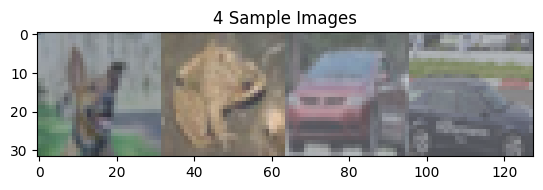


########################################################################################
Inference of "VGG19 (base)"
dataset : cifar10
checkpoint : weights/vgg19/cifar10/VGG19/checkpoint_91.tar

Results
 - Ground truth : ['dog', 'frog', 'automobile', 'automobile']
 - Inference    : ['dog', 'frog', 'automobile', 'truck']
 - Accuracy     : 75.0%
########################################################################################

########################################################################################
Inference of "SE (residual) + SA"
dataset : cifar10
checkpoint : weights/vgg19/cifar10/SE_SA_1/checkpoint_99.tar

Results
 - Ground truth : ['dog', 'frog', 'automobile', 'automobile']
 - Inference    : ['deer', 'frog', 'automobile', 'truck']
 - Accuracy     : 50.0%
########################################################################################

########################################################################################
Inference of "SE + SA"
datase

In [16]:
args.batch_size = 4  # Sample images for inferencing

#############################################
# Load dataset
#############################################
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
if args.dataset == "cifar100":
    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
else:
    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

dataiter = iter(val_loader)
images, labels = next(dataiter)        

###########################################################
# Display sample images
###########################################################
original_img = None
for tensor_img in images:
    rgb_img = deprocess_image(tensor_img.permute(1, 2, 0).numpy()) / 255.0

    if original_img is None:
        original_img = rgb_img
    else:
        original_img = cv2.hconcat([original_img, rgb_img])

fig = plt.figure()
plt.imshow(original_img)
plt.title("%d Sample Images" % args.batch_size)
plt.show()

###########################################################
# Run inference of each model with same sample images
###########################################################
for bt, bn, bw in zip(block_list, name_list, weight_list):
    print()
    print('########################################################################################')
    print('Inference of "%s"' %bn)
    args.block = bt
    args.checkpoint = bw
    run_inference(args, images, labels)
    print('########################################################################################')